In [1]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard as tb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [4]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [532]:
def get_uncompiled_custom_model(
    input_shape,
    output_shape,
    units,
    activation,
    n_blocks,
    layers_per_block,
    scales=[1],
    scale_activation="relu",
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    plain_network=False,
    group_norm=False
):
    
    input_layer = tf.keras.Input(shape=(input_shape,))

    outputs = [None] * len(scales)

    for i, scale in enumerate(scales):
        scale_tensor = wispy.mscalev3.make_scale_tensor(
            input_shape, scale_dimension, scale, dtype=dtype
        )
        scaled_input = wispy.mscalev3.ScaleLayer(scale_tensor)(input_layer)

        x = tf.keras.layers.Dense(units, activation=scale_activation)(scaled_input)

        if not plain_network:
            outputs[i] = []

        for k in range(n_blocks):
            if skip_connection:
                tmp = x
            for j in range(layers_per_block):
                x = tf.keras.layers.Dense(units, activation=activation)(x)
            if skip_connection:
                x = tf.keras.layers.add([x, tmp])
            if not plain_network:
                outputs[i].append(tf.keras.layers.Dense(output_shape, name=f"outputs_{i}_{k}")(x))
            if group_norm:
                x = tfa.layers.GroupNormalization(groups=1)(x)
        if plain_network:
            outputs[i] = tf.keras.layers.Dense(output_shape, name=f"outputs_{i}")(x)
        else:
            outputs[i] = tf.keras.layers.add([output for output in outputs[i]], name=f"outputs_{i}")

#     if plain_network:
#         outputs = tf.keras.layers.Dense(output_shape)(x) 
#     else:
    if len(outputs) > 1:
        outputs = tf.keras.layers.add([output for output in outputs])
    else:
        outputs = outputs[0]

    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)

    return model

def get_compiled_custom_model(model_params_dict, lr, loss='mse'):
    model = get_uncompiled_custom_model(**model_params_dict)

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss=loss, optimizer=optimizer)

    return model

# load data

In [46]:
X_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy')[:1119]
y_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy')[:1119]

X_train_raw = np.float32(X_train_raw)
y_train_raw = np.float32(y_train_raw)

# X_train_raw = X_train_raw[:,0].reshape(-1, 1)
X_train_raw = X_train_raw[:,:2].reshape(-1, 2)

# X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy')[:1119]
# y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy')[:1119]

print(f"X_train_raw.shape: {X_train_raw.shape}")
print(f"y_train_raw.shape: {y_train_raw.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

# lets just use 1D input - i.e., time-series
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")



# X_train = np.float32(X_train_raw)
# y_train = np.float32(y_train)
# X_val = np.float32(X_val)
# y_val = np.float32(y_val)

X_train_raw.shape: (1119, 2)
y_train_raw.shape: (1119, 1)
X_train.shape: (749, 2)
y_train.shape: (749, 1)
X_val.shape: (370, 2)
y_val.shape: (370, 1)


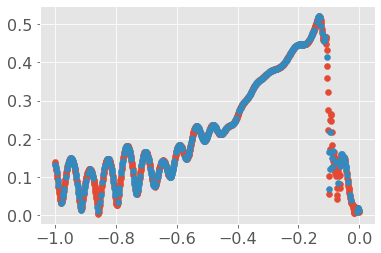

In [55]:
plt.figure()
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_val[:,0], y_val)

# create tf datasets

# base line

In [ ]:
# fewer blocks seems like a good rule of thumb because the later blocks are very small

In [564]:
scales = [1,10,50,100,500]
n_scales = len(scales)
n_blocks = 2
layers_per_block = 5

model_params_dict = dict(
    input_shape=2,
    output_shape=1,
    units=256,
    activation='relu',
    n_blocks=n_blocks,
    layers_per_block=layers_per_block,
    scales=scales,
    scale_activation="s2relu",
    scale_dimension=0,
    dtype=None,
    skip_connection=True,
    plain_network=False,
    group_norm=False
)

In [565]:
test_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=1e-3)

In [566]:
callbacks = [
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
    wispy.callbacks.ThresholdCallback(1e-6),
    tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9)
]

In [567]:
%%time
test_history = test_model.fit(x=X_train, y=y_train, epochs=4001, validation_data=(X_val, y_val), verbose=0, batch_size=200, callbacks=callbacks)

Training:   0%|           0/4001 ETA: ?s,  ?epochs/s

CPU times: user 4min 4s, sys: 1min 7s, total: 5min 12s
Wall time: 1min 17s


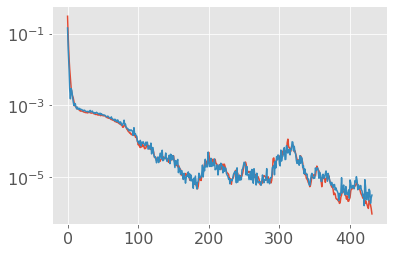

In [568]:
plt.figure()
plt.plot(test_history.history['loss'])
plt.plot(test_history.history['val_loss'])
plt.yscale('log')

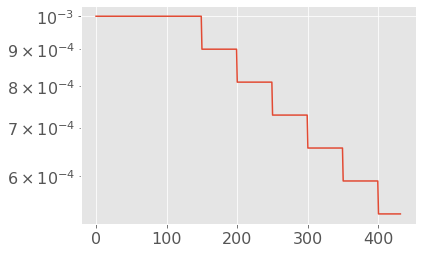

In [569]:
plt.figure()
plt.plot(test_history.history['lr'])
plt.yscale('log')

In [570]:
test_yhat = test_model.predict(X_train)

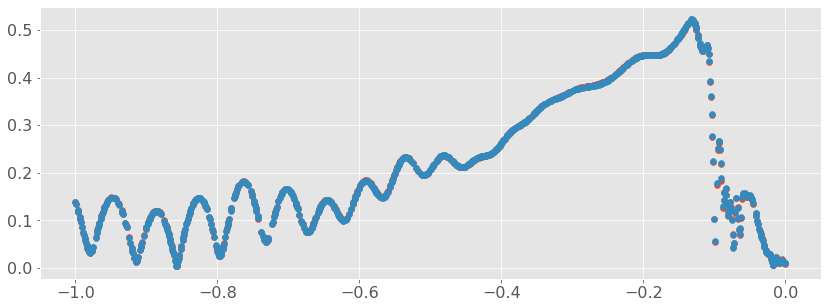

In [571]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], test_yhat)
# plt.xlim(-0.2, 0)

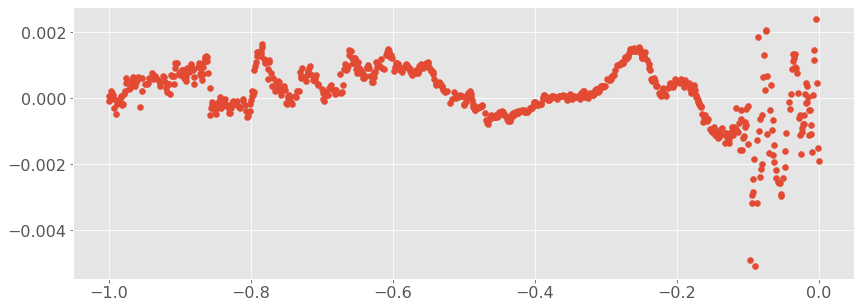

In [572]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-test_yhat)

(1e-13, 0.001)

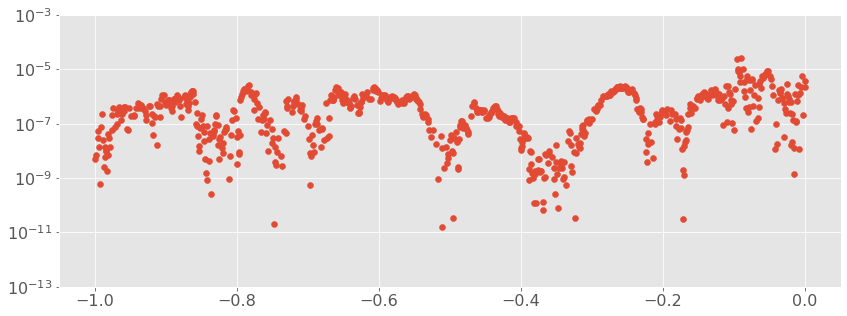

In [573]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,test_yhat))
plt.yscale('log')
plt.ylim(1e-13, 1e-3)

In [574]:
# intermediate outputs

In [575]:
test_model.summary()

Model: "model_418"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_110 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
scale_layer_318 (ScaleLayer)    (None, 2)            0           input_110[0][0]                  
__________________________________________________________________________________________________
scale_layer_319 (ScaleLayer)    (None, 2)            0           input_110[0][0]                  
__________________________________________________________________________________________________
scale_layer_320 (ScaleLayer)    (None, 2)            0           input_110[0][0]                  
__________________________________________________________________________________________

In [576]:
n_blocks

2

In [577]:
int_model = {}
layer_names = [f"outputs_{i}" for i in range(n_scales)]
for layer_name in layer_names:
    layer_output = test_model.get_layer(layer_name).output
    int_model[layer_name] = tf.keras.models.Model(test_model.input, outputs=layer_output)

    
for ii in range(n_scales):
    layer_names = [f"outputs_{ii}_{k}" for k in range(n_blocks)]
    for layer_name in layer_names:
        layer_output = test_model.get_layer(layer_name).output
        int_model[layer_name] = tf.keras.models.Model(test_model.input, outputs=layer_output)

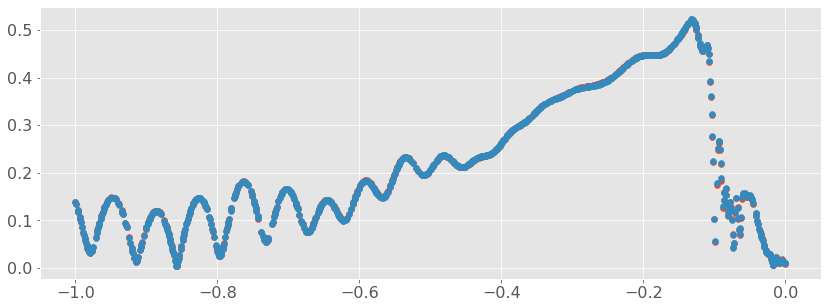

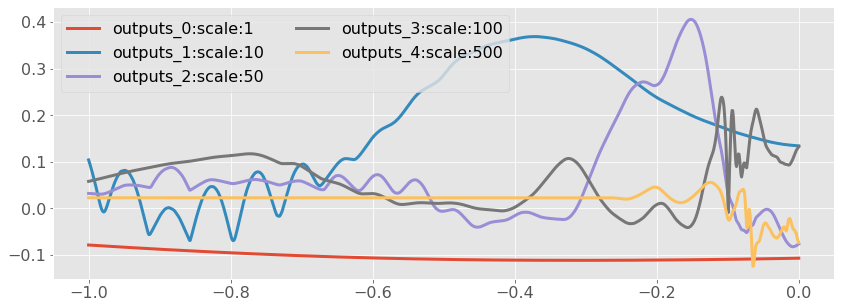

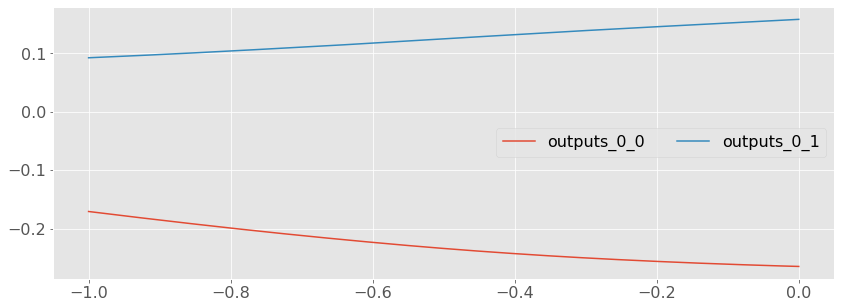

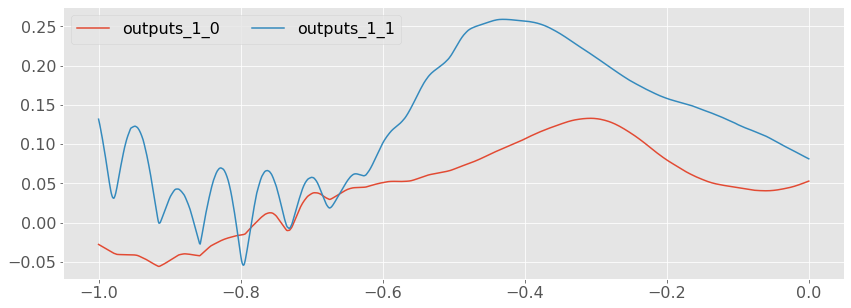

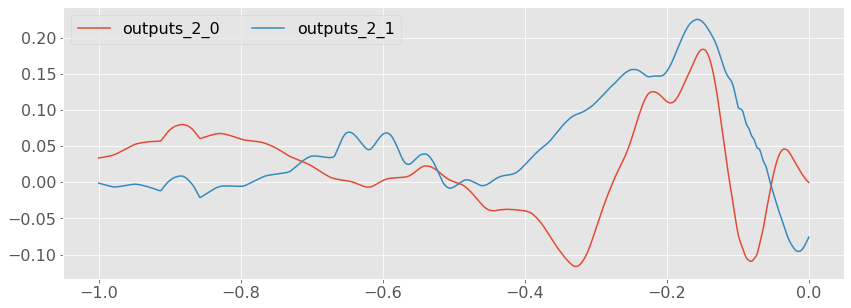

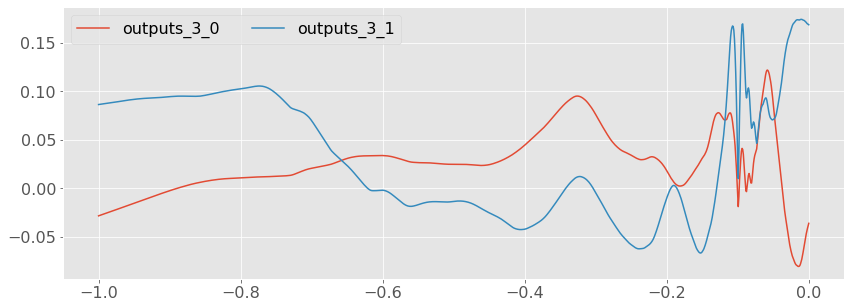

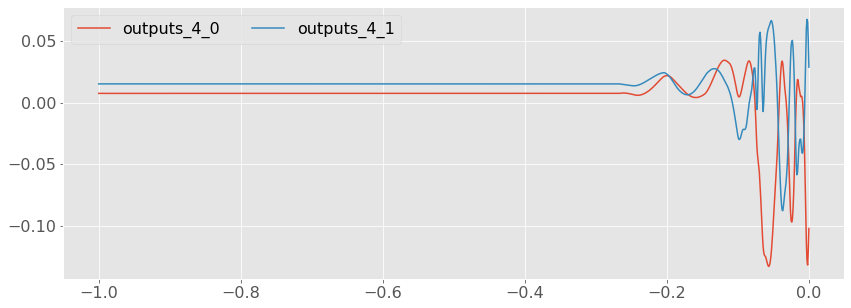

In [578]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train, label='data')
plt.scatter(X_train[:,0], test_yhat)
plt.show()
plt.close()

plt.figure(figsize=(14, 5))
for i in range(n_scales):
    plt.plot(X_train_raw[:,0], int_model[f"outputs_{i}"].predict(X_train_raw), label=f"outputs_{i}:scale:{scales[i]}", lw=3)    
plt.legend(ncol=2)
plt.show()

# int_summed = int_model["outputs_0"].predict(X_train_raw) + int_model["outputs_1"].predict(X_train_raw) + int_model["outputs_2"].predict(X_train_raw)
# plt.plot(X_train_raw[:,0], int_summed)


for ii in range(n_scales):
    plt.figure(figsize=(14, 5))
    for k in range(n_blocks):
        plt.plot(X_train_raw[:,0], int_model[f"outputs_{ii}_{k}"].predict(X_train_raw), label=f"outputs_{ii}_{k}")
    plt.legend(ncol=2)
    plt.show()
    plt.close()

# looping

## plain networks

In [188]:
%%time
plain_models = []
plain_historys = []
n_tries = 10
lr = 1e-3
batch_size = 200
epochs = 1001
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=128,
        activation='relu',
        n_blocks=6,
        layers_per_block=3,
        scales=[1,10,100],
        scale_activation="s2relu",
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        plain_network=True
    )
    plain_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=100)
    ]
    plain_history = plain_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    plain_models.append(plain_model)
    plain_historys.append(plain_history)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 10%|█         | 1/10 [01:29<13:27, 89.71s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 20%|██        | 2/10 [02:59<11:57, 89.66s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 30%|███       | 3/10 [04:29<10:29, 89.92s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 40%|████      | 4/10 [05:59<09:00, 90.07s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 50%|█████     | 5/10 [07:31<07:32, 90.48s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 60%|██████    | 6/10 [09:03<06:04, 91.10s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 70%|███████   | 7/10 [10:36<04:35, 91.85s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 80%|████████  | 8/10 [12:09<03:04, 92.16s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

 90%|█████████ | 9/10 [13:37<01:30, 90.81s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s

100%|██████████| 10/10 [15:08<00:00, 90.85s/it]

CPU times: user 34min 38s, sys: 11min 31s, total: 46min 9s
Wall time: 15min 8s


Text(0.5, 1.0, 'val')

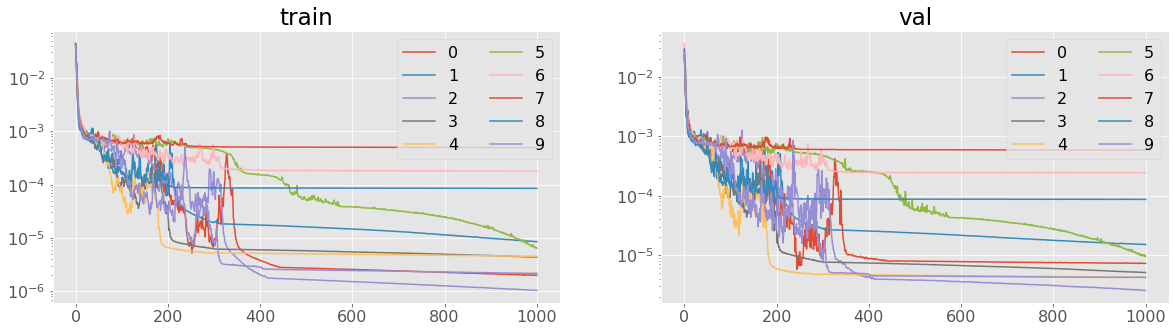

In [189]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

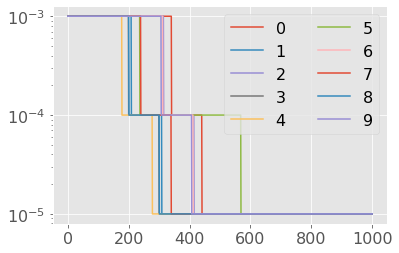

In [205]:
if 'lr' in plain_historys[0].history.keys():
    plt.figure()
    for i, history in enumerate(plain_historys):
        plt.plot(history.history['lr'], label=f'{i}')
    plt.yscale('log')
    plt.legend(ncol=2)

## plain networks with skip_connections

In [190]:
%%time
plain_skip_models = []
plain_skip_historys = []
n_tries = 10
lr = 1e-3
batch_size = 200
epochs = 2001
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=128,
        activation='relu',
        n_blocks=6,
        layers_per_block=3,
        scales=[1,10,100],
        scale_activation="s2relu",
        scale_dimension=0,
        dtype=None,
        skip_connection=True,
        plain_network=True
    )
    plain_skip_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=100)
    ]
    plain_skip_history = plain_skip_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    plain_skip_models.append(plain_skip_model)
    plain_skip_historys.append(plain_skip_history)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 10%|█         | 1/10 [00:21<03:12, 21.43s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 20%|██        | 2/10 [00:41<02:43, 20.45s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 30%|███       | 3/10 [01:14<03:03, 26.23s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 40%|████      | 4/10 [01:33<02:21, 23.54s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 50%|█████     | 5/10 [01:53<01:50, 22.14s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 60%|██████    | 6/10 [02:17<01:31, 22.81s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 70%|███████   | 7/10 [02:41<01:09, 23.18s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 80%|████████  | 8/10 [03:05<00:47, 23.61s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 90%|█████████ | 9/10 [03:26<00:22, 22.67s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

100%|██████████| 10/10 [04:01<00:00, 24.13s/it]

CPU times: user 8min 23s, sys: 3min 16s, total: 11min 40s
Wall time: 4min 1s


Text(0.5, 1.0, 'val')

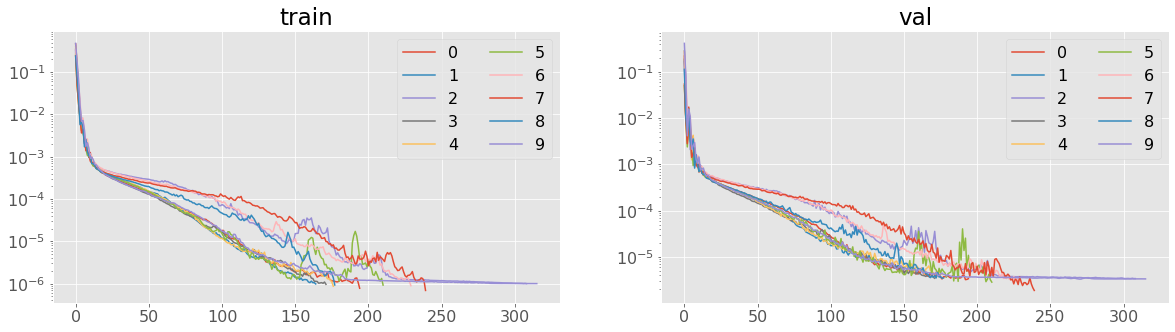

In [191]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

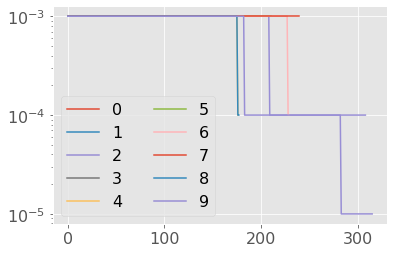

In [204]:
if 'lr' in plain_skip_historys[0].history.keys():
    plt.figure()
    for i, history in enumerate(plain_skip_historys):
        plt.plot(history.history['lr'], label=f'{i}')
    plt.yscale('log')
    plt.legend(ncol=2)

## not plain networks

In [192]:
%%time
custom_models = []
custom_historys = []
n_tries = 10
lr = 1e-3
batch_size = 200
epochs = 2001
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=128,
        activation='relu',
        n_blocks=6,
        layers_per_block=3,
        scales=[1,10,100],
        scale_activation="s2relu",
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        plain_network=False
    )
    custom_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=100)
    ]
    custom_history = custom_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    custom_models.append(custom_model)
    custom_historys.append(custom_history)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 10%|█         | 1/10 [00:23<03:29, 23.32s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 20%|██        | 2/10 [00:50<03:23, 25.39s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 30%|███       | 3/10 [01:17<03:03, 26.16s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 40%|████      | 4/10 [01:40<02:29, 24.89s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 50%|█████     | 5/10 [02:08<02:10, 26.01s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 60%|██████    | 6/10 [02:36<01:46, 26.75s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 70%|███████   | 7/10 [03:04<01:22, 27.36s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 80%|████████  | 8/10 [03:26<00:51, 25.58s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 90%|█████████ | 9/10 [03:51<00:25, 25.35s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

100%|██████████| 10/10 [04:12<00:00, 25.21s/it]

CPU times: user 8min 39s, sys: 3min 29s, total: 12min 9s
Wall time: 4min 12s


Text(0.5, 1.0, 'val')

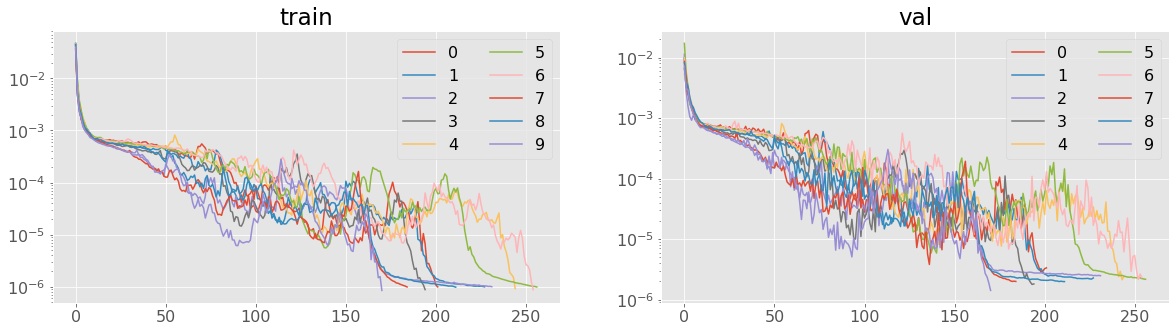

In [193]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(custom_historys):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(custom_historys):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

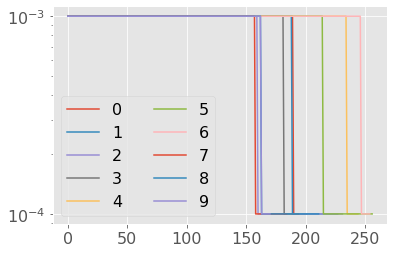

In [203]:
if 'lr' in custom_historys[0].history.keys():
    plt.figure()
    for i, history in enumerate(custom_historys):
        plt.plot(history.history['lr'], label=f'{i}')
    plt.yscale('log')
    plt.legend(ncol=2)

## not plain networks with skip_connections

In [194]:
%%time
custom_skip_models = []
custom_skip_historys = []
n_tries = 10
lr = 1e-3
batch_size = 200
epochs = 2001
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=128,
        activation='relu',
        n_blocks=6,
        layers_per_block=3,
        scales=[1,10,100],
        scale_activation="s2relu",
        scale_dimension=0,
        dtype=None,
        skip_connection=True,
        plain_network=False
    )
    custom_skip_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=100)
    ]
    custom_skip_history = custom_skip_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    custom_skip_models.append(custom_skip_model)
    custom_skip_historys.append(custom_skip_history)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 10%|█         | 1/10 [02:12<19:56, 132.93s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 20%|██        | 2/10 [02:47<10:00, 75.12s/it] 

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 30%|███       | 3/10 [03:26<06:51, 58.76s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 40%|████      | 4/10 [06:07<09:54, 99.04s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 50%|█████     | 5/10 [08:52<10:13, 122.80s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 60%|██████    | 6/10 [10:01<06:57, 104.32s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 70%|███████   | 7/10 [11:27<04:55, 98.56s/it] 

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 80%|████████  | 8/10 [14:23<04:06, 123.28s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 90%|█████████ | 9/10 [16:18<02:00, 120.60s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

100%|██████████| 10/10 [16:43<00:00, 100.34s/it]

CPU times: user 34min 45s, sys: 16min 18s, total: 51min 4s
Wall time: 16min 43s


Text(0.5, 1.0, 'val')

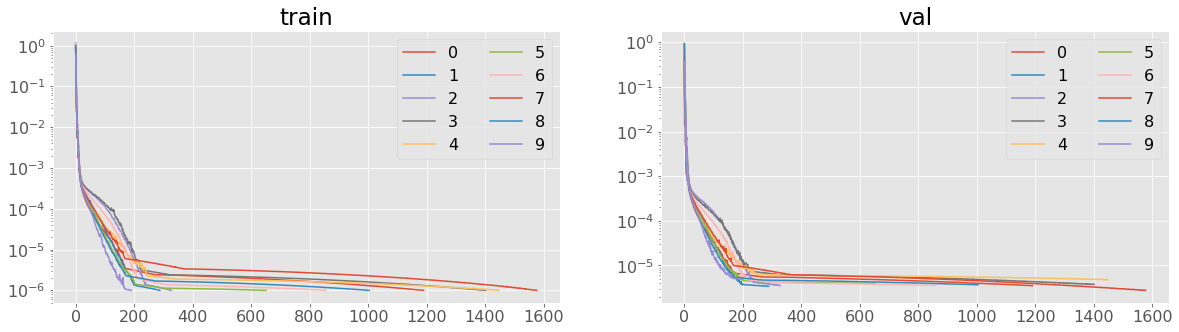

In [195]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

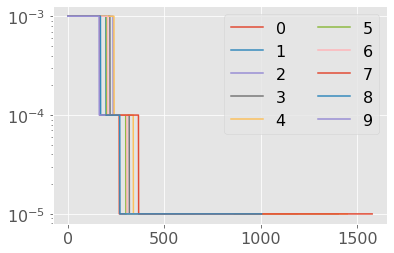

In [202]:
if 'lr' in custom_skip_historys[0].history.keys():
    plt.figure()
    for i, history in enumerate(custom_skip_historys):
        plt.plot(history.history['lr'], label=f'{i}')
    plt.yscale('log')
    plt.legend(ncol=2)

## comparison

Text(0.5, 1.0, 'val')

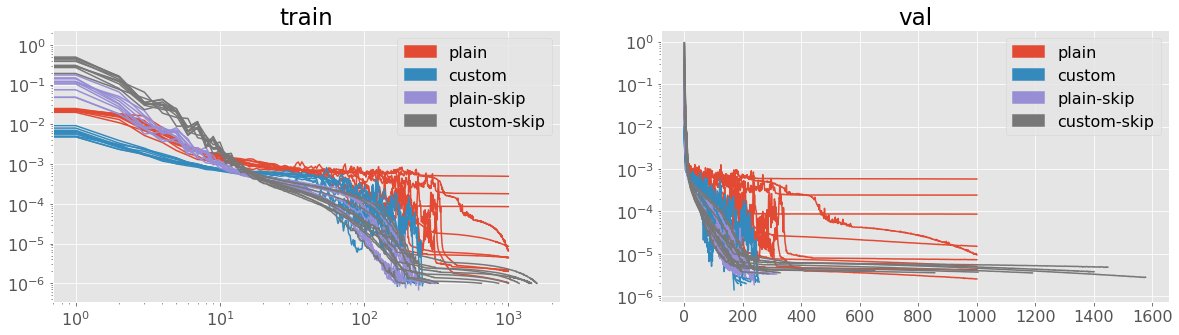

In [239]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['loss'], c='C0')
for i, history in enumerate(custom_historys):
    plt.plot(history.history['loss'], c='C1')
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['loss'], c='C2')
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
    mpatches.Patch(color='C1', label='custom'),
    mpatches.Patch(color='C2', label='plain-skip'),
    mpatches.Patch(color='C3', label='custom-skip')])
plt.title('train')
plt.xscale('log')

plt.subplot(1,2,2)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['val_loss'], c='C0')
for i, history in enumerate(custom_historys):
    plt.plot(history.history['val_loss'], c='C1')
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['val_loss'], c='C2')
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['val_loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
    mpatches.Patch(color='C1', label='custom'),
    mpatches.Patch(color='C2', label='plain-skip'),
    mpatches.Patch(color='C3', label='custom-skip')])
plt.title('val')

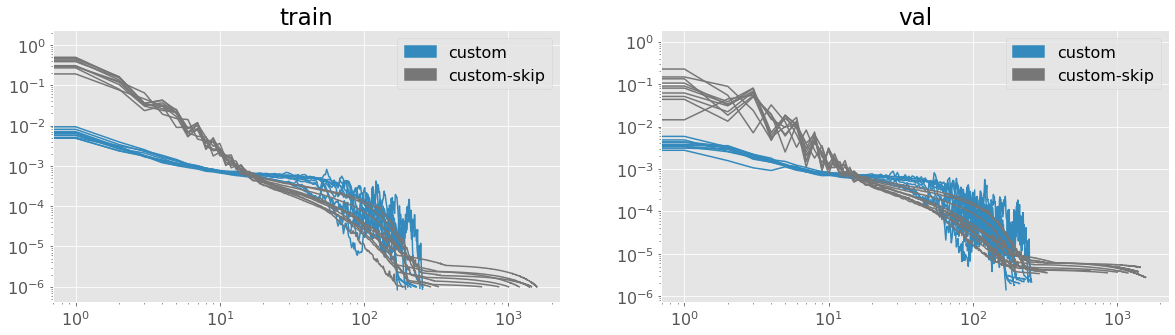

In [235]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
# for i, history in enumerate(plain_historys):
#     plt.plot(history.history['loss'], c='C0')
for i, history in enumerate(custom_historys):
    plt.plot(history.history['loss'], c='C1')
# for i, history in enumerate(plain_skip_historys):
#     plt.plot(history.history['loss'], c='C2')
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
#     mpatches.Patch(color='C0', label='plain'),
    mpatches.Patch(color='C1', label='custom'),
#     mpatches.Patch(color='C2', label='plain-skip'),
    mpatches.Patch(color='C3', label='custom-skip')
])
plt.title('train')
# plt.xlim(0,300)
plt.xscale('log')

plt.subplot(1,2,2)
# for i, history in enumerate(plain_historys):
#     plt.plot(history.history['val_loss'], c='C0')
for i, history in enumerate(custom_historys):
    plt.plot(history.history['val_loss'], c='C1')
# for i, history in enumerate(plain_skip_historys):
#     plt.plot(history.history['val_loss'], c='C2')
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['val_loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
#     mpatches.Patch(color='C0', label='plain'),
    mpatches.Patch(color='C1', label='custom'),
#     mpatches.Patch(color='C2', label='plain-skip'),
    mpatches.Patch(color='C3', label='custom-skip')
])
plt.title('val')
plt.xscale('log')

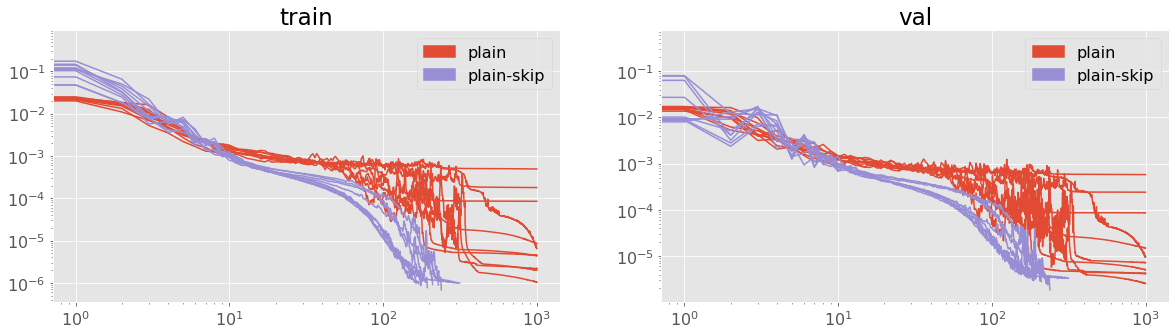

In [237]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['loss'], c='C0')
# for i, history in enumerate(custom_historys):
#     plt.plot(history.history['loss'], c='C1')
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['loss'], c='C2')
# for i, history in enumerate(custom_skip_historys):
#     plt.plot(history.history['loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
#     mpatches.Patch(color='C1', label='custom'),
    mpatches.Patch(color='C2', label='plain-skip'),
#     mpatches.Patch(color='C3', label='custom-skip')
])
plt.title('train')
# plt.xlim(0,300)
plt.xscale('log')

plt.subplot(1,2,2)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['val_loss'], c='C0')
# for i, history in enumerate(custom_historys):
#     plt.plot(history.history['val_loss'], c='C1')
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['val_loss'], c='C2')
# for i, history in enumerate(custom_skip_historys):
#     plt.plot(history.history['val_loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
#     mpatches.Patch(color='C1', label='custom'),
    mpatches.Patch(color='C2', label='plain-skip'),
#     mpatches.Patch(color='C3', label='custom-skip')
])
plt.title('val')
plt.xscale('log')

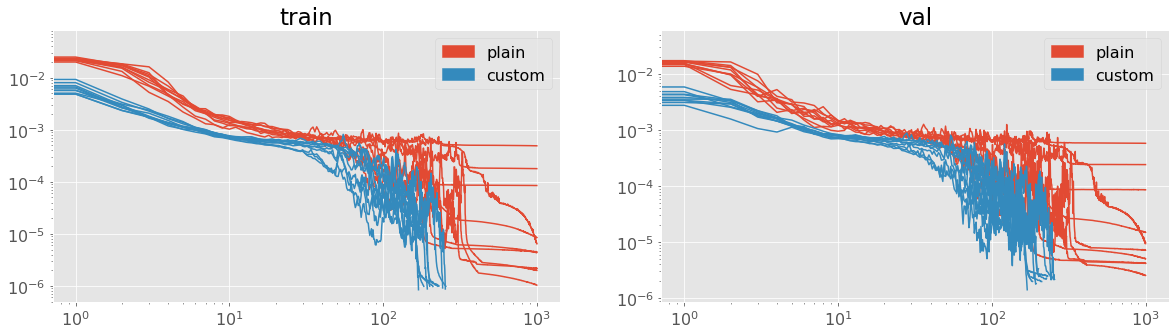

In [238]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['loss'], c='C0')
for i, history in enumerate(custom_historys):
    plt.plot(history.history['loss'], c='C1')
# for i, history in enumerate(plain_skip_historys):
#     plt.plot(history.history['loss'], c='C2')
# for i, history in enumerate(custom_skip_historys):
#     plt.plot(history.history['loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
    mpatches.Patch(color='C1', label='custom'),
#     mpatches.Patch(color='C2', label='plain-skip'),
#     mpatches.Patch(color='C3', label='custom-skip')
])
plt.title('train')
plt.xscale('log')

plt.subplot(1,2,2)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['val_loss'], c='C0')
for i, history in enumerate(custom_historys):
    plt.plot(history.history['val_loss'], c='C1')
# for i, history in enumerate(plain_skip_historys):
#     plt.plot(history.history['val_loss'], c='C2')
# for i, history in enumerate(custom_skip_historys):
#     plt.plot(history.history['val_loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
    mpatches.Patch(color='C1', label='custom'),
#     mpatches.Patch(color='C2', label='plain-skip'),
#     mpatches.Patch(color='C3', label='custom-skip')
])
plt.title('val')
plt.xscale('log')

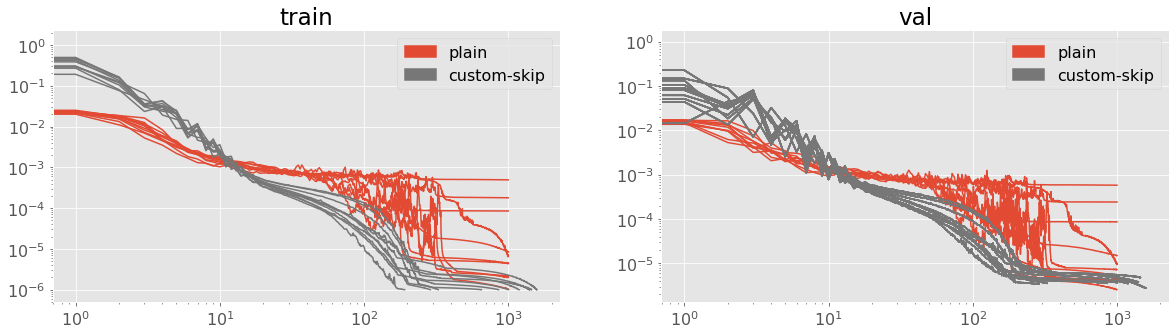

In [232]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['loss'], c='C0')
# for i, history in enumerate(custom_historys):
#     plt.plot(history.history['loss'], c='C1')
# for i, history in enumerate(plain_skip_historys):
#     plt.plot(history.history['loss'], c='C2')
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
#     mpatches.Patch(color='C1', label='custom'),
#     mpatches.Patch(color='C2', label='plain-skip'),
    mpatches.Patch(color='C3', label='custom-skip')
])
plt.title('train')
plt.xscale('log')

plt.subplot(1,2,2)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['val_loss'], c='C0')
#     for i, history in enumerate(custom_historys):
#         plt.plot(history.history['val_loss'], c='C1')
#     for i, history in enumerate(plain_skip_historys):
#         plt.plot(history.history['val_loss'], c='C2')
    for i, history in enumerate(custom_skip_historys):
        plt.plot(history.history['val_loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
#     mpatches.Patch(color='C1', label='custom'),
#     mpatches.Patch(color='C2', label='plain-skip'),
    mpatches.Patch(color='C3', label='custom-skip')
])
plt.title('val')
plt.xscale('log')

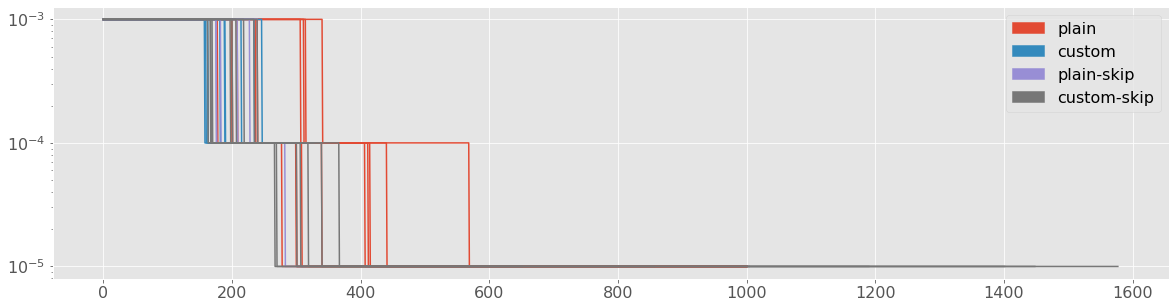

In [227]:
if 'lr' in plain_historys[0].history.keys():
    plt.figure(figsize=(20,5))
    for i, history in enumerate(plain_historys):
        plt.plot(history.history['lr'], c='C0')
    for i, history in enumerate(custom_historys):
        plt.plot(history.history['lr'], c='C1')
    for i, history in enumerate(plain_skip_historys):
        plt.plot(history.history['lr'], c='C2')
    for i, history in enumerate(custom_skip_historys):
        plt.plot(history.history['lr'], c='C3')
    plt.yscale('log')
    plt.legend(handles=[
        mpatches.Patch(color='C0', label='plain'),
        mpatches.Patch(color='C1', label='custom'),
        mpatches.Patch(color='C2', label='plain-skip'),
        mpatches.Patch(color='C3', label='custom-skip')])

### conclusion

In [ ]:
# there seems to be a big improvement between my new "residual" connection and a plain network (without traditions skip-connections)
# compare the 'plain' with the 'custom' curves in the plots above.

# However, using skip-connection i.e. traditional resnet stuff as well results in the plain network matching the performance.
# skip-connections improve the loss curves in the sense that they do not jump around as much

In [197]:
best_idx = np.argmin([history.history['loss'][-1] for history in custom_historys])
print(best_idx)

9


In [198]:
worst_idx = np.argmax([history.history['loss'][-1] for history in custom_historys])
print(worst_idx)

2


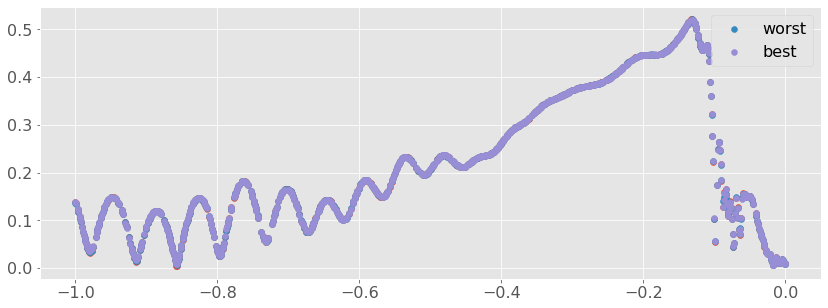

In [199]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], custom_models[worst_idx].predict(X_train), label='worst')
plt.scatter(X_train[:,0], custom_models[best_idx].predict(X_train), label='best')
# plt.xlim(-0.2, 0)
plt.legend()

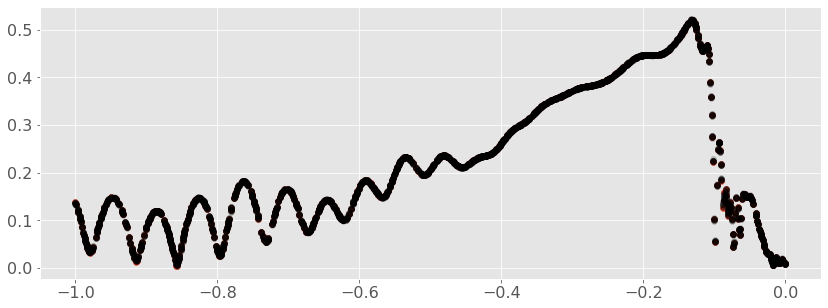

In [200]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
for c_model in custom_models:
    plt.scatter(X_train[:,0], c_model.predict(X_train), c='k', alpha=0.2)
# plt.xlim(-0.2, 0)